In [1]:
from __future__ import print_function, division

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess


from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting

## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [2]:
ds = util.load_soundings()
util.add_monthly_insolation(ds)
ds = util.adjust_lev(ds)

Dropped levels [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29]


# Climlab

All tendencies must be in K/sec (see Climlab energy_budget documentation and self.heating_rate attribute): https://climlab.readthedocs.io/en/latest/_modules/climlab/process/energy_budget.html#EnergyBudget

In [3]:
#### Find the surface diffk average over 12 months at CO2 = .00038 ####
timestep = 3600 #seconds
ram_dict_annual_mean_diffk = {}
ram_dict_annual_mean_diffk = ram_model.fill_ensemble(ds, ram_dict_annual_mean_diffk, timestep, surface_diffk = None)
surface_diffk_average = ram_model.annual_mean_sfc_diffk(ds, ram_dict_annual_mean_diffk)

In [4]:
#### Find our initial output for the model with a set average surface diffk #### 
ram_dict = {}
ram_dict = ram_model.fill_ensemble(ds, ram_dict, timestep, surface_diffk = surface_diffk_average)

# Output (initial and over time)

### Initial

In [8]:
###set up lists and variables
diagnostics_list = list(ram_dict[.0001]['January'].diagnostics.keys())
temp_list = ['Ts','Tatm']
adv_dict = {'advection_Ts':'Ts','advection_Tatm':'Tatm'}
output_list = temp_list + diagnostics_list + list(adv_dict.keys()) + ['lev_bounds'] + ['time']
print('Outputs available ' + str(output_list))
print('CO2 values ' + str(ds['CO2_list'].values))
print('timestep ' + str(timestep) + ' seconds')


Outputs available ['Ts', 'Tatm', 'OLR', 'OLRclr', 'OLRcld', 'TdotLW', 'TdotLW_clr', 'LW_sfc', 'LW_sfc_clr', 'LW_flux_up', 'LW_flux_down', 'LW_flux_net', 'LW_flux_up_clr', 'LW_flux_down_clr', 'LW_flux_net_clr', 'ASR', 'ASRclr', 'ASRcld', 'TdotSW', 'TdotSW_clr', 'SW_sfc', 'SW_sfc_clr', 'SW_flux_up', 'SW_flux_down', 'SW_flux_net', 'SW_flux_up_clr', 'SW_flux_down_clr', 'SW_flux_net_clr', 'total_sfc_flux_init', 'theta_init', 'dtheta_dz_surf_init', 'surface_diffk', 'theta', 'dtheta_dz', 'atm_diffk', 'atm_turbulent_flux', 'sfc_turbulent_flux', 'atm_hr', 'sfc_hr', 'hr', 'z', 'z_bounds', 'advection_Ts', 'advection_Tatm', 'lev_bounds', 'time']
CO2 values [0.0001  0.0002  0.00038 0.00076 0.001   0.0015 ]
timestep 3600 seconds


In [9]:
### create dictionary for results
results_dict = {}

In [10]:
### results at first timestep
results_dict[0] = {}
for output in output_list:
    results_dict[0][output] = {}
    for CO2 in ds['CO2_list'].values:
        results_dict[0][output][CO2] = {}
        for m in np.asarray(ds['month']):
            results_dict[0][output][CO2][m] = {}
            if output in (diagnostics_list):
                results_dict[0][output][CO2][m] = (ram_dict[CO2][m].diagnostics[output])
            if output in temp_list:
                results_dict[0][output][CO2][m] = list(ram_dict[CO2][m].state[output])
            if output in list(adv_dict.keys()):
                results_dict[0][output][CO2][m] = list(ram_dict[CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
            if output == 'lev_bounds':
                results_dict[0][output][CO2][m] = list(ram_dict[CO2][m].lev_bounds)
            if output == 'time':
                results_dict[0]['time'][CO2][m] = list(ram_dict[CO2][m].time)


### Timestep forward

In [11]:
steps = 2190
### results for each timestep
for i in range(steps):
    #step model forward
    results_dict[(i+1)*timestep] = {}
    for count, output in enumerate(output_list):
        results_dict[(i+1)*timestep][output] = {}
        for CO2 in ds['CO2_list'].values:
            results_dict[(i+1)*timestep][output][CO2] = {}
            for m in np.asarray(ds['month']):
                results_dict[(i+1)*timestep][output][CO2][m] = {}
                if count==0:
                    ram_dict[CO2][m].step_forward()
                #add outputs/diagnostics
                if output in (diagnostics_list):
                    results_dict[(i+1)*timestep][output][CO2][m] = (ram_dict[CO2][m].diagnostics[output])
                if output in temp_list:
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[CO2][m].state[output])
                if output in list(adv_dict.keys()):
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
                if output == 'lev_bounds':
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[CO2][m].lev_bounds)

#### parameters for plots

In [123]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076
time1 = (0)*timestep
time2 = (steps)*timestep
month = 'December'

###create a dict of output names and the z bounds they align with
output_dict = {}
output_dict['bounds'] = {'Tatm':'z','TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds',
               'theta_init':'z', 'theta':'z', 'dtheta_dz':'z_bounds', 'atm_diffk':'z_bounds', 
               'atm_turbulent_flux':'z_bounds','atm_hr':'z', 
               'hr':'z', 'advection_Tatm':'z'}
atm_process_dict = {'Tatm':'Atmospheric Temperature (K)',
                    'atm_diffk':r'Atmospheric $\kappa$ ($\frac{m^2}{s}$)',
                    'dtheta_dz':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)',
                    'theta':r'$\theta$',
                    'SW_flux_net_clr':r'Shortwave Flux ($\frac{W}{m^2}$)',
                    'LW_flux_net_clr':r'Longwave Flux ($\frac{W}{m^2}$)', 
                    'TdotLW_clr':r'Longwave Heating Rate ($\frac{K}{s}$)',
                    'TdotSW_clr':r'Shortwave Heating Rate ($\frac{K}{s}$)',
                    'atm_hr':r'Turbulent Heating Rate ($\frac{K}{s}$)',
                    'advection_Tatm':r'Advective Heating Rate ($\frac{K}{s}$)'}
single_level_process = {'LW_sfc_clr':r'Surface Longwave Flux ($\frac{W}{m^2}$)', 
                        'Ts': 'Surface Temperature (K)', 
                        'ASRclr':r'Absorbed Solar Radiation, Top of Atmosphere ($\frac{W}{m^2}$)', 
                        'SW_sfc_clr':r'Surface Shortwave Flux ($\frac{W}{m^2}$)', 
                        'total_sfc_flux_init':r'Total Initial Surface Flux ($\frac{W}{m^2}$)', 
                        'dtheta_dz_surf_init':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)', 
                        'surface_diffk':r'Surface $\kappa$ ($\frac{m^2}{s}$)', 
                        'sfc_turbulent_flux':r'Surface Turbulent Flux ($\frac{W}{m^2}$)', 
                        'sfc_hr':r'Surface Turbulent Heating Rate ($\frac{K}{s}$)', 
                        'advection_Ts':r'Surface Advection ($\frac{K}{s}$)', 
                        'OLR':r'Outgoing Longwave Radiation, Top of Atmosphere ($\frac{W}{m^2}$)'}

#### CO2 difference plots

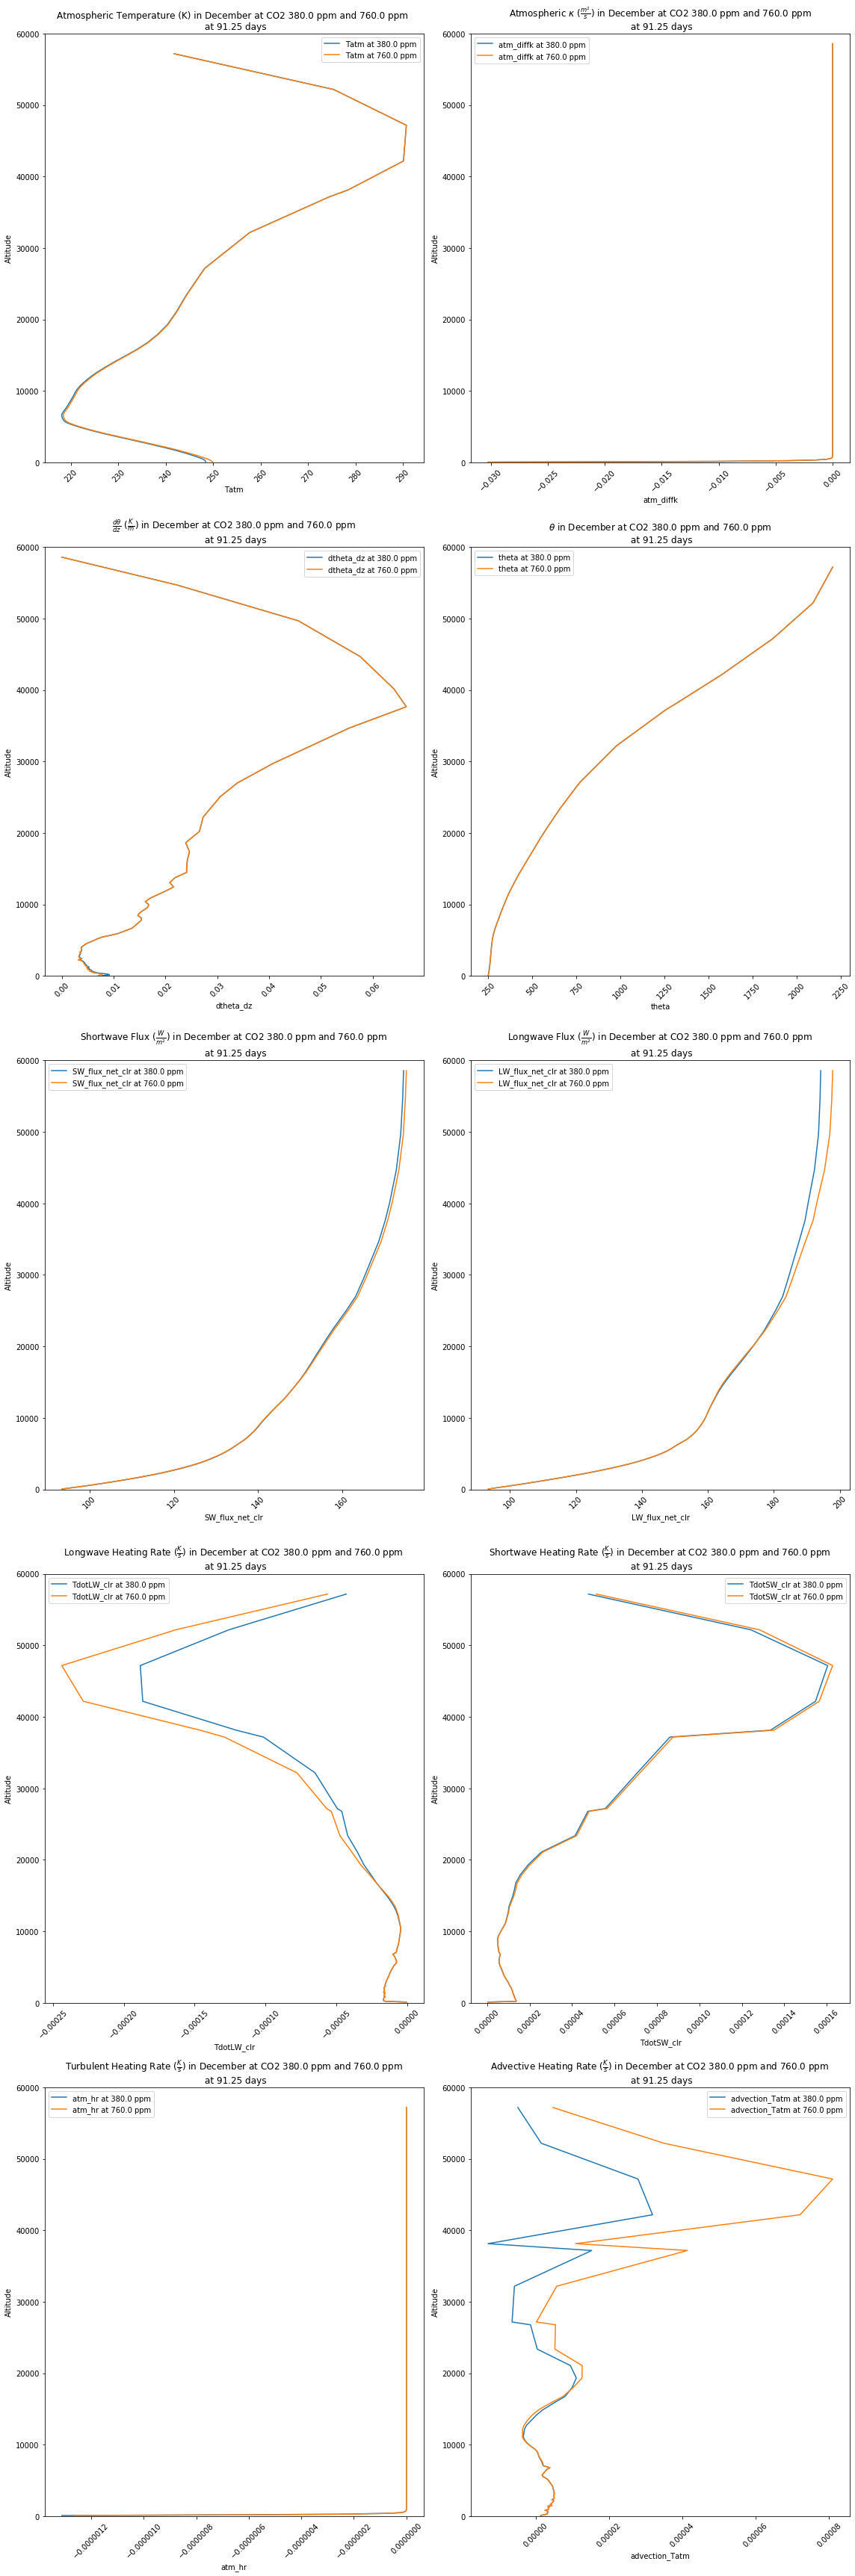

In [124]:
plotting.plot_co2_dif(
    results_dict, 
    outputs = ['Tatm','atm_diffk','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','atm_hr','advection_Tatm'],
    output_dict = output_dict, CO2_conc1 = CO2_conc1,CO2_conc2 = CO2_conc2, 
    time1 = time2, month = month,figsize = [16,48], rows =5, columns =2, ylim = 60000, diff_only = False
)
plt.savefig(f'../figures/{month}_CO2_dif_{CO2_conc1}_{CO2_conc2}_{time2}.png', bbox_inches = 'tight', dpi = 150)

#### time difference plots

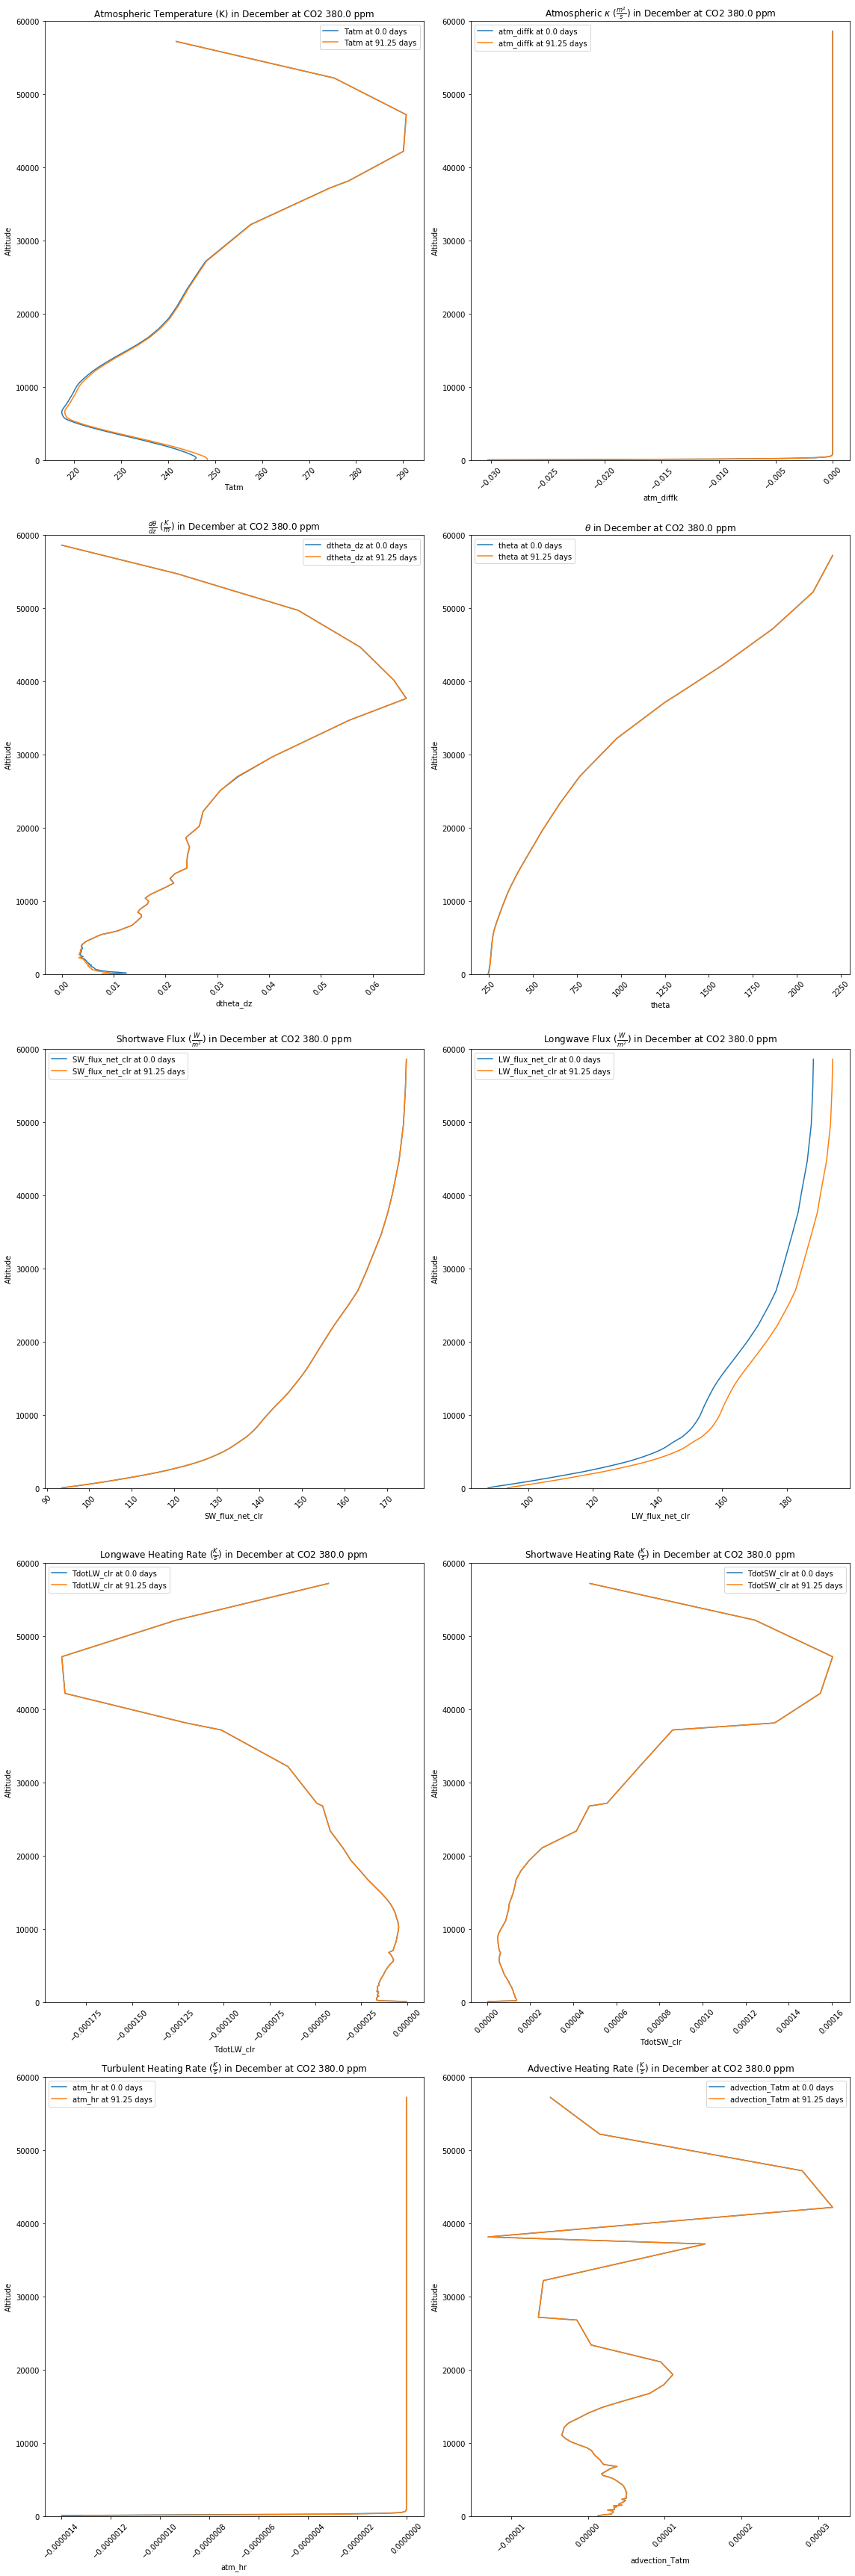

In [125]:
plotting.plot_time_dif(
    results_dict,
    outputs = ['Tatm','atm_diffk','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','atm_hr','advection_Tatm'],
    output_dict = output_dict, CO2_conc1 = CO2_conc1, time1 = time1, time2 = time2, month = month, 
    figsize = [16,48], rows =5, columns =2, ylim = 60000, diff_only =False
)
plt.savefig(f'../figures/{month}_time_dif_{CO2_conc1}_{time1}_{time2}.png', bbox_inches = 'tight', dpi = 150)

#### single level process plots: 

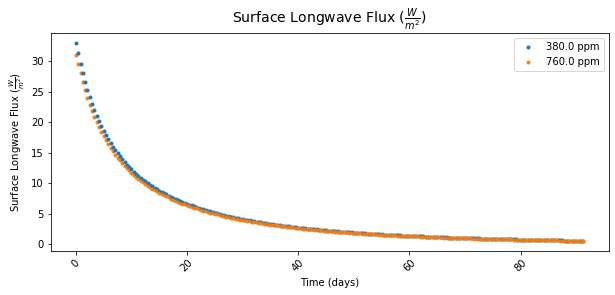

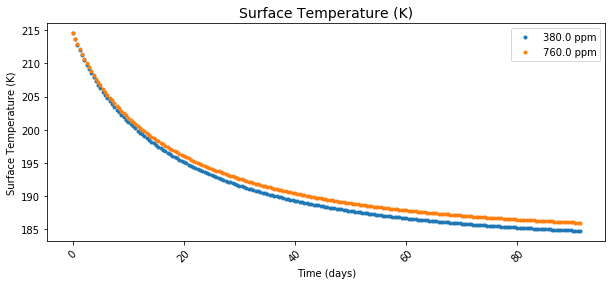

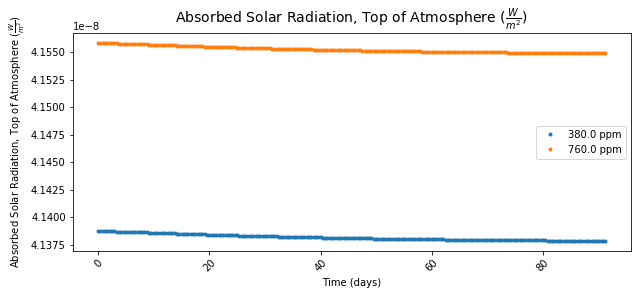

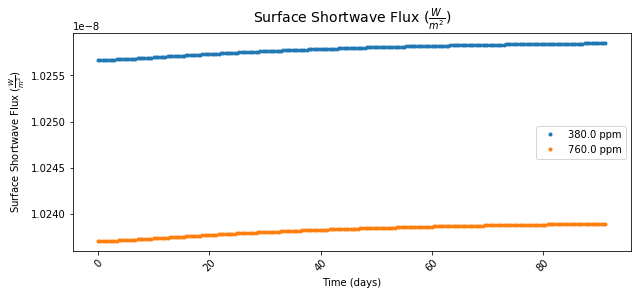

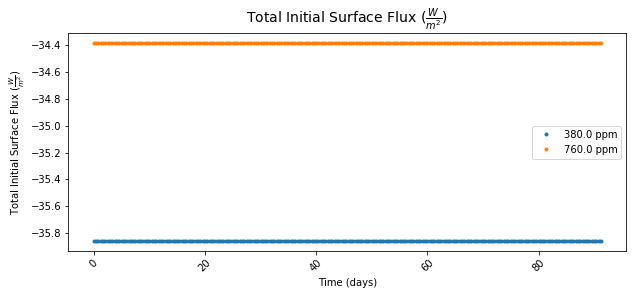

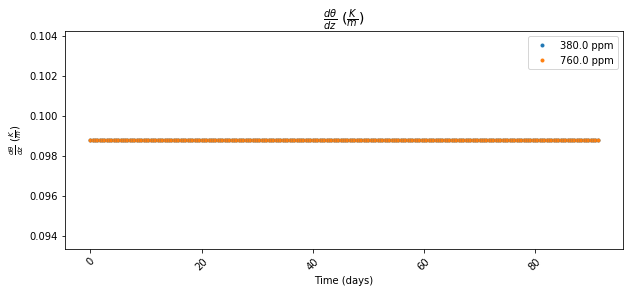

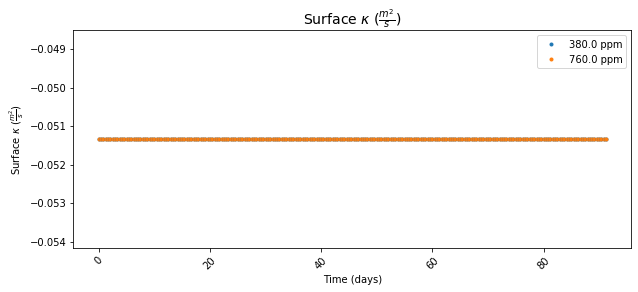

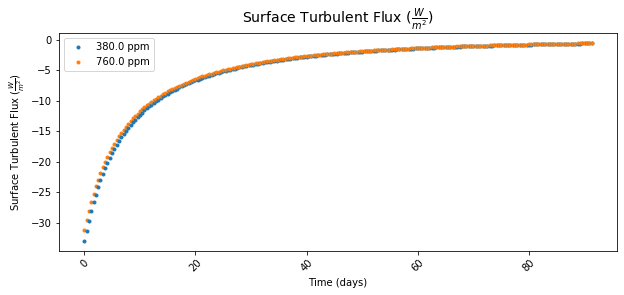

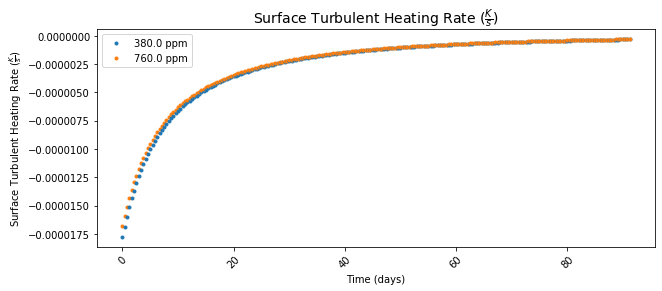

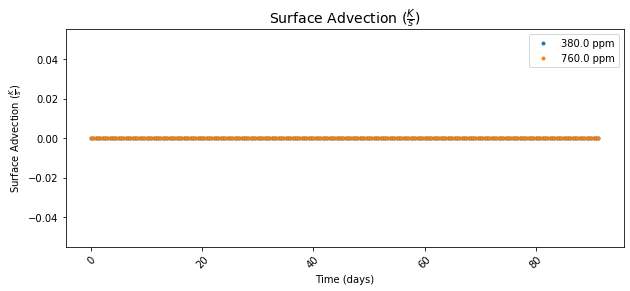

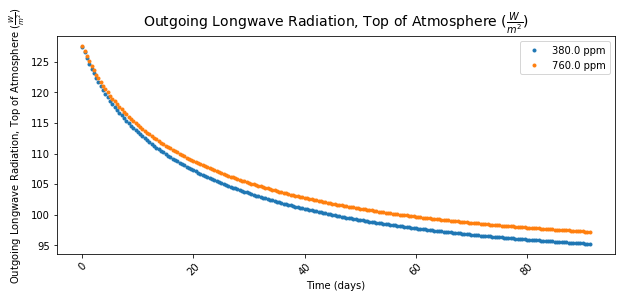

In [121]:
for process in single_level_process.keys():
    plotting.single_level_plot(results_dict,process, CO2_conc1, CO2_conc2, month)
    plt.ylabel(single_level_process[process])
    plt.title(single_level_process[process], fontsize = 14)
    #plt.savefig(f'../figures/{month}_{process}_{CO2_conc1}_{CO2_conc2}_{steps}steps.png', bbox_inches = 'tight', dpi = 150)

#### sum of heating rates

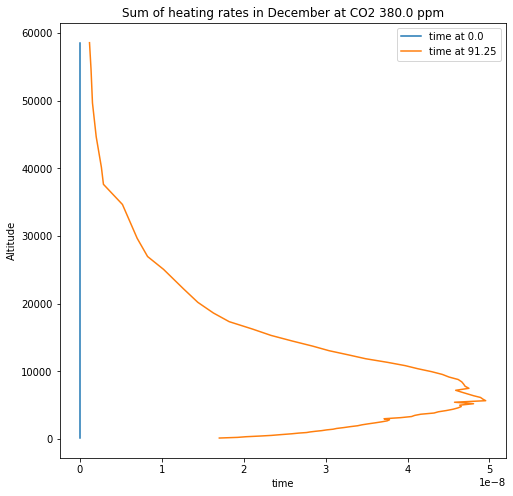

In [55]:
### plot the sum of our heating rates

fig = plt.figure(figsize = [8,8])

ax = fig.add_subplot(1, 1, 1)
x1 = np.asarray(results_dict[time1]['TdotLW_clr'][CO2_conc1][month]/86400) + np.asarray(results_dict[time1]['TdotSW_clr'][CO2_conc1][month]/86400) + np.asarray(results_dict[time1]['atm_hr'][CO2_conc1][month]) + np.asarray((results_dict[time1]['advection_Tatm'][CO2_conc1][month]))

y1 = results_dict[time1]['z_bounds'][CO2_conc1][month][:-1]

x2 = np.asarray(results_dict[time2]['TdotLW_clr'][CO2_conc1][month]/86400) + np.asarray(results_dict[time2]['TdotSW_clr'][CO2_conc1][month]/86400)+ np.asarray(results_dict[time2]['atm_hr'][CO2_conc1][month]) + np.asarray(results_dict[time2]['advection_Tatm'][CO2_conc1][month])

y2 = results_dict[time2]['z_bounds'][CO2_conc1][month][:-1]

plt.plot(x1, y1, color = 'C0', label = f'{output} at {time1/climlab.constants.seconds_per_day}');
plt.plot(x2, y2, color = 'C1', label = f'{output} at {time2/climlab.constants.seconds_per_day}');

plt.legend()
plt.ylabel('Altitude')
plt.xlabel(f'{output}')
plt.title(f'Sum of heating rates in {month} at CO2 {CO2_conc1 * 1e6} ppm')
plt.savefig(f'sum_heating_rates{time1}_{time2}_{CO2_conc1}.png', bbox_inches = 'tight',dpi = 150)

### which is better to calculate the surface turbulent flux-- atm diffk or sfc diffk?

In [140]:
(results_dict[time1]['atm_diffk'][CO2_conc1]['July'] * results_dict[time1]['dtheta_dz'][CO2_conc1]['July'] * 1003 * 1.05)[-1]

-2.957839664824472

In [142]:
(results_dict[time1]['surface_diffk'][CO2_conc1]['July'] * results_dict[time1]['dtheta_dz'][CO2_conc1]['July'] * 1003 * 1.05)[-1]

-4.9543162132061935

### find entire column energy balance

In [128]:
### check the surface energy budget at beginning, middle and end
for time in [time1, time2/2, time2]:
    print(f'Surface energy budget at {time}: ')
    print((np.asarray(results_dict[time]['SW_sfc_clr'][CO2_conc1][month])- 
           np.asarray(results_dict[time]['LW_sfc_clr'][CO2_conc1][month]) - 
           np.asarray(results_dict[time]['sfc_turbulent_flux'][CO2_conc1][month])))
    print('W/m^2')
    
### calculate advective heat flux at the top layer
top_layer_thickness = results_dict[time1]['z_bounds'][CO2_conc1][month][0]- results_dict[time1]['z_bounds'][CO2_conc1][month][1]
density = 1.05 #density of air kg/m^3
cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)

### check the TOA energy budget at the beginning, middle and end
top_layer_adv_flux = results_dict[time1]['advection_Tatm'][CO2_conc1][month][0] * cp_air * density * top_layer_thickness #K/s * kg/m3 * J/kg*K * m 
for time in [time1, time2/2, time2]:
    print(f'TOA energy budget at {time}: ')
    print(np.asarray(results_dict[time]['OLR'][CO2_conc1][month]) - 
           np.asarray(results_dict[time]['ASR'][CO2_conc1][month]) +
          top_layer_adv_flux)
    print('W/m^2')
    
### check the TOA energy budget at the beginning, middle and end
for time in [time1, time2/2, time2]:
    print(f'TOA energy budget at {time}: ')
    print(np.asarray(results_dict[time]['LW_flux_net'][CO2_conc1][month][1]) - 
           np.asarray(results_dict[time]['SW_flux_net'][CO2_conc1][month][1]) +
          top_layer_adv_flux)
    print('W/m^2')

Surface energy budget at 0: 
[0.]
W/m^2
Surface energy budget at 3942000.0: 
[0.]
W/m^2
Surface energy budget at 7884000: 
[0.]
W/m^2
TOA energy budget at 0: 
[-6.29597944]
W/m^2
TOA energy budget at 3942000.0: 
[-0.87336703]
W/m^2
TOA energy budget at 7884000: 
[-0.34090932]
W/m^2
TOA energy budget at 0: 
-6.274119787779437
W/m^2
TOA energy budget at 3942000.0: 
-0.8514948291870148
W/m^2
TOA energy budget at 7884000: 
-0.31904437680371345
W/m^2


#### solar insolation

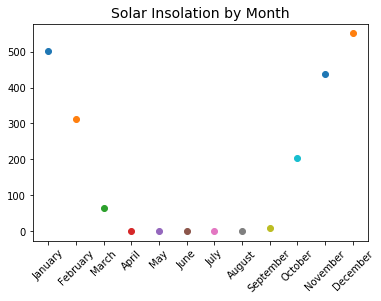

In [79]:
###plot solar insolation by month

fig, ax = plt.subplots(figsize = [6,4])
for m in np.array(ds['month']):
    plt.plot(m, ram_dict[.00038][m].subprocess.Radiation.insolation, 'o')
    plt.xticks(rotation = 45)
    plt.title('Solar Insolation by Month', fontsize = 14)